# 项目2

首先导入csv表格数据

In [53]:
import pandas as pd
import numpy as np
import os
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import io, transform
from tqdm import tqdm
import time
data_df=pd.read_csv('chinese_mnist.csv')

检查表格里的数据是否有缺漏

In [54]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum() / data.isnull().count() * 100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data(data_df)

,Total,Percent
character,0,0.0
value,0,0.0
code,0,0.0
sample_id,0,0.0
suite_id,0,0.0


没有缺漏。

同样地，检查图像数据并将信息导入data_df。

In [55]:
IMAGE_PATH = '.\\data\\'

image_files = list(os.listdir(IMAGE_PATH))
print("图像数：%d" %len(image_files))
# if no missing in the data, it will print '15000'

图像数：15000


In [56]:
def create_file_name(x):
    file_name = f"input_{x[0]}_{x[1]}_{x[2]}.jpg"
    return file_name
def read_image_sizes(file_name):
    image = io.imread(IMAGE_PATH + file_name)
    return list(image.shape)


data_df['file'] = data_df.apply(create_file_name, axis=1)
file_names = list(data_df['file'])

df = pd.DataFrame(np.stack(data_df['file'].apply(read_image_sizes)), columns = ['width', 'height'])
data_df = pd.concat([data_df, df], axis = 1)

data_df.head()

,suite_id,sample_id,code,value,character,file,width,height
0,1,1,10,9,九,input_1_1_10.jpg,64,64
1,1,10,10,9,九,input_1_10_10.jpg,64,64
2,1,2,10,9,九,input_1_2_10.jpg,64,64
3,1,3,10,9,九,input_1_3_10.jpg,64,64
4,1,4,10,9,九,input_1_4_10.jpg,64,64


In [57]:
data_df.character.value_counts()

八    1000
七    1000
百    1000
十    1000
二    1000
一    1000
五    1000
九    1000
六    1000
三    1000
千    1000
万    1000
四    1000
零    1000
亿    1000
Name: character, dtype: int64

由于t-sne执行时间比较长，这里先选用4500项数据。这样的话，训练集：验证集：测试集的比例为5:3:2.

In [58]:
def create_datasets(df):
    imgs = []
    for filename in tqdm(df['file']):
        img = io.imread(IMAGE_PATH + filename)
        img = transform.resize(img, (64, 64))
        img = img.flatten()
        imgs.append(img)
        
    imgs = np.array(imgs)
    df = pd.get_dummies(df['character'])
    return imgs, df


data_df = data_df.iloc[np.random.permutation(len(data_df))]
data_df = data_df[0 : 4500]
imgs, df = create_datasets(data_df)

100%|█████████████████████████████████████████████████████████████████████████████| 4500/4500 [00:12<00:00, 357.33it/s]


In [59]:
data_df.character.value_counts()

亿    324
万    320
一    316
十    306
八    305
三    303
二    301
九    298
七    297
四    295
零    290
百    289
五    287
六    285
千    284
Name: character, dtype: int64

先使用pca降维保留95%特征。

In [60]:
def Z_centered(dataMat):
    rows,cols = dataMat.shape
    meanVal = np.mean(dataMat, axis = 0)  # 按列求均值，即求各个特征的均值
    meanVal = np.tile(meanVal,(rows, 1))
    newdata = dataMat - meanVal
    return newdata, meanVal

# 最小化降维造成的损失，确定k
def Percentage2n(eigVals, percentage):
    sortArray = np.sort(eigVals)
    # 逆转为降序
    sortArray = sortArray[-1::-1]  
    arraySum = sum(sortArray)
    tmpSum = 0
    num = 0
    for i in sortArray:
        tmpSum += i
        num += 1
        if tmpSum >= arraySum * percentage:
            return num

# 得到最大的k个特征值和特征向量
def EigDV(covMat, p):
    D, V = np.linalg.eig(covMat) # 得到特征值和特征向量
    k = Percentage2n(D, p) # 确定k值
    print("保留95%信息，降维后的特征个数：" + str(k) + "\n")
    eigenvalue = np.argsort(D)
    K_eigenValue = eigenvalue[-1:-(k+1):-1]
    K_eigenVector = V[:,K_eigenValue]
    return K_eigenValue, K_eigenVector

# 得到降维后的数据
def getlowDataMat(DataMat, K_eigenVector):
    return DataMat * K_eigenVector
 
# 重构数据
def Reconstruction(lowDataMat, K_eigenVector, meanVal):
    reconDataMat = lowDataMat * K_eigenVector.T + meanVal
    return reconDataMat
 
# PCA算法
def Pca(data, p):
    dataMat = np.mat(data)
    # 数据中心化
    dataMat, meanVal = Z_centered(dataMat)
    # 计算协方差矩阵
    covMat = np.cov(dataMat, rowvar = 0)
    # 得到最大的k个特征值和特征向量
    D, V = EigDV(covMat, p)
    # 得到降维后的数据
    lowDataMat = getlowDataMat(dataMat, V)
    # 重构数据
    # reconDataMat = Reconstruction(lowDataMat, V, meanVal)
    return np.array(lowDataMat.real), V
 
Y_pca, V = Pca(imgs, 0.95)

保留95%信息，降维后的特征个数：637



In [61]:
print(Y_pca.shape)

(4500, 637)


先把所有图像数据进行降维，再分隔数据集。尝试t-sne算法进一步降维。

Computing pairwise distances...
Computing pair_prob for point 0 of 4500 ...
Computing pair_prob for point 500 of 4500 ...
Computing pair_prob for point 1000 of 4500 ...
Computing pair_prob for point 1500 of 4500 ...
Computing pair_prob for point 2000 of 4500 ...
Computing pair_prob for point 2500 of 4500 ...
Computing pair_prob for point 3000 of 4500 ...
Computing pair_prob for point 3500 of 4500 ...
Computing pair_prob for point 4000 of 4500 ...
Mean value of sigma:  0.8347205415361384
Iteration  100 : error is  4.074142698400556
Iteration  200 : error is  1.7039092502274131
Iteration  300 : error is  1.658353734811702
Running time: 8522.8673576 Seconds


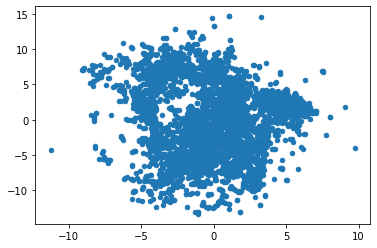

In [134]:
'''
代码参考了Laurens van der Maaten开放出的t-sne代码, 并没有用类进行实现,主要是优化了计算的实现
'''
def cal_pairwise_dist(x):
    '''计算pairwise 距离, x是matrix
    (a-b)^2 = a^w + b^2 - 2*a*b
    '''
    sum_x = np.sum(np.square(x), 1)
    dist = np.add(np.add(-2 * np.dot(x, x.T), sum_x).T, sum_x)
    return dist


def cal_perplexity(dist, idx = 0, beta = 1.0):
    '''计算perplexity, D是距离向量，
    idx指dist中自己与自己距离的位置，beta是高斯分布参数
    这里的perp仅计算了熵，方便计算
    '''
    prob = np.exp(-dist * beta)
    # 设置自身prob为0
    prob[idx] = 0
    sum_prob = np.sum(prob)
    perp = np.log(sum_prob + 1e-12) + beta * np.sum(dist * prob) / (sum_prob + 1e-12)
    prob /= (sum_prob + 1e-12)
    return perp, prob


def seach_prob(x, tol = 1e-5, perplexity = 30.0):
    '''二分搜索寻找beta,并计算pairwise的prob
    '''

    # 初始化参数
    print("Computing pairwise distances...")
    (n, d) = x.shape
    dist = cal_pairwise_dist(x)
    pair_prob = np.zeros((n, n))
    beta = np.ones((n, 1))
    # 取log，方便后续计算
    base_perp = np.log(perplexity + 1e-12)

    for i in range(n):
        if i % 500 == 0:
            print("Computing pair_prob for point %s of %s ..." %(i,n))

        betamin = -np.inf
        betamax = np.inf
        perp, this_prob = cal_perplexity(dist[i], i, beta[i])

        # 二分搜索,寻找最佳sigma下的prob
        perp_diff = perp - base_perp
        tries = 0
        while np.abs(perp_diff) > tol and tries < 50:
            if perp_diff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2
                else:
                    beta[i] = (beta[i] + betamax) / 2
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2
                else:
                    beta[i] = (beta[i] + betamin) / 2

            # 更新perb,prob值
            perp, this_prob = cal_perplexity(dist[i], i, beta[i])
            perp_diff = perp - base_perp
            tries = tries + 1
        # 记录prob值
        pair_prob[i,] = this_prob
    print("Mean value of sigma: ", np.mean(np.sqrt(1 / beta)))
    return pair_prob


def tsne(x, no_dims = 15, perplexity = 30.0, max_iter = 300):
    '''t-sne算法
    先使用PCA降维到initial_dims维，再用t-sne降维到 no_dims维.
    '''

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array x should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # 初始化参数和变量
    (n, d) = x.shape
    initial_momentum = 0.5
    final_momentum = 0.8
    # eta 学习速率
    eta = 6000
    min_gain = 0.01
    y = np.random.randn(n, no_dims)
    dy = np.zeros((n, no_dims))
    iy = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # 对称化
    P = seach_prob(x, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    # early exaggeration
    P = P * 4
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):
        # Compute pairwise affinities
        sum_y = np.sum(np.square(y), 1)
        num = 1 / (1 + np.add(np.add(-2 * np.dot(y, y.T), sum_y).T, sum_y))
        num[range(n), range(n)] = 0
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dy[i,:] = np.sum(np.tile(PQ[:,i] * num[:,i], (no_dims, 1)).T * (y[i,:] - y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dy > 0) != (iy > 0)) + (gains * 0.8) * ((dy > 0) == (iy > 0))
        gains[gains < min_gain] = min_gain
        iy = momentum * iy - eta * (gains * dy)
        y = y + iy
        y = y - np.tile(np.mean(y, 0), (n, 1))
        # Compute current value of cost function
        if (iter + 1) % 100 == 0:
            if iter > 100:
                C = np.sum(P * np.log(P / Q))
            else:
                C = np.sum( P / 4 * np.log( P / 4 / Q))
            print("Iteration ", (iter + 1), ": error is ", C)
        # Stop lying about P-values
        if iter == 100:
            P = P / 4
    return y


start = time.perf_counter()
Y = tsne(Y_pca, 100, 50)
end = time.perf_counter()
print('Running time: %s Seconds'%(end-start))
plt.scatter(Y[:,0], Y[:,1], 20)
plt.show()

In [135]:
print(Y.shape)

(4500, 100)


分隔数据集（为降低测试成本，初期测试时不使用十折交叉验证）

In [62]:
def trainTestSplit(imgs, y, length, start, end):
    X_test = imgs[start * length : end*length, :]
    y_test = df[start * length : end*length]
    y_test_index = list(y_test.index)
    # 都转换为list来判定成员资格
    y_test_flag = y.index.isin(y_test_index)  
    diff_flag = [not f for f in y_test_flag]
    X_train = imgs[diff_flag]
    y_train = y[diff_flag]
    return X_train, y_train, X_test, y_test

In [136]:
def trainTestSplit(imgs, y, length, start, end):
    X_test = imgs[start * length : end*length, :]
    y_test = df[start * length : end*length]
    y_test_index = list(y_test.index)
    # 都转换为list来判定成员资格
    y_test_flag = y.index.isin(y_test_index)  
    diff_flag = [not f for f in y_test_flag]
    X_train = imgs[diff_flag]
    y_train = y[diff_flag]
    return X_train, y_train, X_test, y_test



X_train, y_train, X_test, y_test = trainTestSplit(Y, df, 450, 0, 1)
print(len(y_test))
print(len(y_train))

450
4050


至此，数据集导入、降维、分割初步完成。

np数组Y存储了图像特征信息，大小为4500, 50, 并被分割为训练集X_train与测试集X_test，分别存储了后4050与前450的图像的特征信息。

df存储了图像对应的手写汉字，并被分割为训练集y_train与测试集y_test，分别存储了后4050与前450的图像对应的手写汉字。

在初步完成模型调试后，可以参考项目1的代码，调用trainTestSplit函数完成10折交叉验证，并以此稍微进一步调参，最后评估模型性能。交叉验证集应使用与最初的训练集不同的数据。

In [63]:
# 使用仅pca降维后数据集
X_pca_train, y_train, X_pca_test, y_test = trainTestSplit(Y_pca, df, 450, 0, 1)

np数组Y_pca存储了图像特征信息，大小为4500, 637, 并被分割为训练集X_pca_train与测试集X_pca_test，分别存储了后4050与前450的图像的特征信息。

df存储了图像对应的手写汉字，并被分割为训练集y_train与测试集y_test，分别存储了后4050与前450的图像对应的手写汉字

sne对困惑度perplexity的调整比较有鲁棒性，给定之后，使用二分搜索的方式寻找合适的sigma。

调参时建议参考吴恩达第6周pdf与我的第一个模型（里面有详细的经验总结），可以从梯度下降500（300）次、α=0.5开始调，先10倍10倍调后细调。若准确率稳定在50%以下则可能是模型或模型评估有错，可以尝试输出结果、不同种类手写数字识别率可视化检验。若无错，模型性能不好，如果没有调参过的话，首先是参数的问题。然后是降维的问题，因为降维的参数也没调过。最后再改数据集规模，1500和更大区别不大了，数据集规模增大会耗时，应最后再做。注意数据集规模越大，α和perplexity越大。

<font face="微软雅黑" size=5 color=#A52A2A >1.仅pca降维后进行逻辑回归多分类处理

In [69]:
# 仅pca降维后进行逻辑回归多分类处理
train_X = X_pca_train
train_Y = y_train.values
test_X =  X_pca_test
test_Y = y_test.values
print(train_X.shape)
print(train_Y.shape)

(4050, 637)
(4050, 15)


In [70]:
k = train_X.shape[1]  # k记录维度数量

In [71]:
# 逻辑回归的sigmoid函数和计算cost function的函数
def sigmoid(z):
    return 1/(1+np.exp(-z))

lamda = 1
def calculate_loss(X, y, W, b, lamda):
    A = sigmoid(np.dot(X, W.T) + b)
    # 加1e-6是因为防止为0，log0不存在
    first = y * np.log(A + 1e-6)
    second = (1-y) * np.log(1-A + 1e-6)
    reg = np.sum(np.power(W[1:],2))*(lamda/(2*len(X)))
    
    
    return -np.sum(first+second)/len(X)

# 初始化W和b两个参数
np.random.seed(1)
W = np.random.rand(15, k)
b = np.ones(15)

In [ ]:
# 训练过程

# 保存loss值的list
loss = []
loss.append(calculate_loss(train_X, train_Y, W, b, lamda))

# 学习率
learning_rate = 0.05
# 迭代100次
for i in range(3000):
    # 参数W，b进行梯度下降变化过程
    
    reg = W[1:]*(lamda/len(train_X))
    reg = np.insert(reg, 0, values=0, axis=0)
    
    t1 = W - learning_rate * np.dot(np.transpose(sigmoid(np.dot(train_X, W.T) + b) - train_Y), train_X) / len(train_X) - reg*learning_rate  
    t2 = b - learning_rate * np.sum(np.transpose(sigmoid(np.dot(train_X, W.T) + b) - train_Y), axis=1) / len(train_X)
    W = t1
    b = t2
    
    if (i+1)%100 == 0:
        print("已完成迭代%d"%(i+1) + "次")
        
    
    loss.append(calculate_loss(train_X, train_Y, W, b, lamda))
# 可视化显示迭代过程中的代价函数值
plt.plot(loss)
plt.show()

已完成迭代100次
已完成迭代200次


In [ ]:
# 预测
res = sigmoid(np.dot(test_X, W.T) + b)
res_idx = np.argmax(res, axis=1)
test_idx = np.argmax(test_Y, axis=1)
cnt = 0
flag2 = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
flag1 = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
ss = [[0 for i in range(15)] for j in range(15)]
for i in range(len(res_idx)):
    flag1[test_idx[i]] += 1
    if res_idx[i] == test_idx[i]:
        cnt += 1
        flag2[test_idx[i]] += 1
    ss[test_idx[i]][res_idx[i]] += 1
print('总准确度为: ' + str(cnt/len(res_idx)))
print('零的识别度为' + str(flag2[0]/flag1[0]))
print('一的识别度为' + str(flag2[1]/flag1[1]))
print('二的识别度为' + str(flag2[2]/flag1[2]))
print('三的识别度为' + str(flag2[3]/flag1[3]))
print('四的识别度为' + str(flag2[4]/flag1[4]))
print('五的识别度为' + str(flag2[5]/flag1[5]))
print('六的识别度为' + str(flag2[6]/flag1[6]))
print('七的识别度为' + str(flag2[7]/flag1[7]))
print('八的识别度为' + str(flag2[8]/flag1[8]))
print('九的识别度为' + str(flag2[9]/flag1[9]))
print('十的识别度为' + str(flag2[10]/flag1[10]))
print('百的识别度为' + str(flag2[11]/flag1[11]))
print('千的识别度为' + str(flag2[12]/flag1[12]))
print('万的识别度为' + str(flag2[13]/flag1[13]))
print('亿的识别度为' + str(flag2[14]/flag1[14]))
print('混淆矩阵：')
for i in range(0,15):
    for j in range(0,15):
        print('%3d'%ss[i][j],end=' ')
    print()
for i in range(0,15):
    t1 = 0
    for j in range(0,15):
        t1 += ss[i][j]
    t2 = 0
    for j in range(0,15):
        t2 += ss[j][i]
    print(str(i) + '精确率: ' + str(ss[i][i]/t2))
    print(str(i) + '召回率: ' + str(ss[i][i]/t1))

<font face="微软雅黑" size=5 color=#A52A2A > 2.tsne降维后逻辑回归多分类处理

In [137]:

train_X = X_train
train_Y = y_train.values
test_X =  X_test
test_Y = y_test.values
print(train_X.shape)
print(train_Y.shape)
k = train_X.shape[1]  # k记录维度数量

(4050, 100)
(4050, 15)


In [138]:
# 逻辑回归的sigmoid函数和计算cost function的函数
def sigmoid(z):
    return 1/(1+np.exp(-z))

lamda = 1
def calculate_loss(X, y, W, b, lamda):
    A = sigmoid(np.dot(X, W.T) + b)
    # 加1e-6是因为防止为0，log0不存在
    first = y * np.log(A + 1e-6)
    second = (1-y) * np.log(1-A + 1e-6)
    reg = np.sum(np.power(W[1:],2))*(lamda/(2*len(X)))
    
    
    return -np.sum(first+second)/len(X)

# 初始化W和b两个参数
np.random.seed(1)
W = np.random.rand(15, k)
b = np.ones(15)

已完成迭代500次
已完成迭代1000次
已完成迭代1500次
已完成迭代2000次
已完成迭代2500次
已完成迭代3000次
已完成迭代3500次
已完成迭代4000次
已完成迭代4500次
已完成迭代5000次


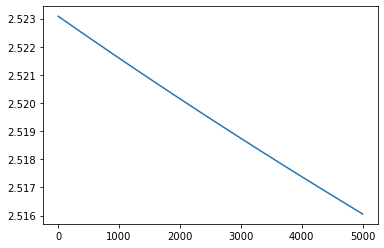

In [178]:
# 训练过程

# 保存loss值的list
loss = []
loss.append(calculate_loss(train_X, train_Y, W, b, lamda))

# 学习率
learning_rate = 0.005
# 迭代100次
for i in range(5000):
    # 参数W，b进行梯度下降变化过程
    
    reg = W[1:]*(lamda/len(train_X))
    reg = np.insert(reg, 0, values=0, axis=0)
    
    t1 = W - learning_rate * np.dot(np.transpose(sigmoid(np.dot(train_X, W.T) + b) - train_Y), train_X) / len(train_X) - reg*learning_rate  
    t2 = b - learning_rate * np.sum(np.transpose(sigmoid(np.dot(train_X, W.T) + b) - train_Y), axis=1) / len(train_X)
    W = t1
    b = t2
    
    if (i+1)%500 == 0:
        print("已完成迭代%d"%(i+1) + "次")
        
    
    loss.append(calculate_loss(train_X, train_Y, W, b, lamda))
# 可视化显示迭代过程中的代价函数值
plt.plot(loss)
plt.show()

In [179]:
# 预测
res = sigmoid(np.dot(test_X, W.T) + b)
res_idx = np.argmax(res, axis=1)
test_idx = np.argmax(test_Y, axis=1)
cnt = 0
flag2 = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
flag1 = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
ss = [[0 for i in range(15)] for j in range(15)]
for i in range(len(res_idx)):
    flag1[test_idx[i]] += 1
    if res_idx[i] == test_idx[i]:
        cnt += 1
        flag2[test_idx[i]] += 1
    ss[test_idx[i]][res_idx[i]] += 1
print('总准确度为: ' + str(cnt/len(res_idx)))
print('零的识别度为' + str(flag2[0]/flag1[0]))
print('一的识别度为' + str(flag2[1]/flag1[1]))
print('二的识别度为' + str(flag2[2]/flag1[2]))
print('三的识别度为' + str(flag2[3]/flag1[3]))
print('四的识别度为' + str(flag2[4]/flag1[4]))
print('五的识别度为' + str(flag2[5]/flag1[5]))
print('六的识别度为' + str(flag2[6]/flag1[6]))
print('七的识别度为' + str(flag2[7]/flag1[7]))
print('八的识别度为' + str(flag2[8]/flag1[8]))
print('九的识别度为' + str(flag2[9]/flag1[9]))
print('十的识别度为' + str(flag2[10]/flag1[10]))
print('百的识别度为' + str(flag2[11]/flag1[11]))
print('千的识别度为' + str(flag2[12]/flag1[12]))
print('万的识别度为' + str(flag2[13]/flag1[13]))
print('亿的识别度为' + str(flag2[14]/flag1[14]))
print('混淆矩阵：')
for i in range(0,15):
    for j in range(0,15):
        print('%3d'%ss[i][j],end=' ')
    print()
for i in range(0,15):
    t1 = 0
    for j in range(0,15):
        t1 += ss[i][j]
    t2 = 0
    for j in range(0,15):
        t2 += ss[j][i]
    print(str(i) + '精确率: ' + str(ss[i][i]/t2))
    print(str(i) + '召回率: ' + str(ss[i][i]/t1))

总准确度为: 0.41555555555555557
零的识别度为0.32432432432432434
一的识别度为0.4
二的识别度为0.35135135135135137
三的识别度为0.3870967741935484
四的识别度为0.2692307692307692
五的识别度为0.24242424242424243
六的识别度为0.3548387096774194
七的识别度为0.59375
八的识别度为0.8666666666666667
九的识别度为0.2413793103448276
十的识别度为0.2857142857142857
百的识别度为0.4
千的识别度为0.3103448275862069
万的识别度为0.41935483870967744
亿的识别度为0.8695652173913043
混淆矩阵：
 12   1   9   6   0   2   0   0   0   2   2   2   1   0   0 
  2  12   4   0   2   1   0   1   0   1   3   3   0   1   0 
  5   0  13   0   4   0   0   1   0   5   0   1   1   4   3 
  3   0   0  12   0   6   5   2   0   1   0   1   1   0   0 
  2   0   5   1   7   0   1   2   1   2   1   2   0   0   2 
  5   1   0  12   0   8   5   1   0   1   0   0   0   0   0 
  0   0   0  11   0   4  11   1   0   2   1   1   0   0   0 
  4   1   0   0   2   0   2  19   0   1   1   1   0   1   0 
  0   0   1   0   0   0   0   1  26   1   0   0   0   1   0 
  3   1   5   3   5   1   1   0   0   7   1   1   0   0   1 
  3   3   3   1   0

<font face="微软雅黑" size=5 color=#A52A2A > 3.减少tsne降维后的样本数量进行逻辑回归

In [182]:
Y = Y[0 : 2000]
df = df[0 : 2000]
X_train_2, y_train_2, X_test_2, y_test_2 = trainTestSplit(Y, df, 300, 0, 1)
print(len(y_test_2))
print(len(y_train_2))

300
1700


In [183]:
train_X = X_train_2
train_Y = y_train_2.values
test_X =  X_test_2
test_Y = y_test_2.values
print(train_X.shape)
print(train_Y.shape)
k = train_X.shape[1]  # k记录维度数量

(1700, 100)
(1700, 15)


In [184]:
# 逻辑回归的sigmoid函数和计算cost function的函数
def sigmoid(z):
    return 1/(1+np.exp(-z))

lamda = 1
def calculate_loss(X, y, W, b, lamda):
    A = sigmoid(np.dot(X, W.T) + b)
    # 加1e-6是因为防止为0，log0不存在
    first = y * np.log(A + 1e-6)
    second = (1-y) * np.log(1-A + 1e-6)
    reg = np.sum(np.power(W[1:],2))*(lamda/(2*len(X)))
    
    
    return -np.sum(first+second)/len(X)

# 初始化W和b两个参数
np.random.seed(1)
W = np.random.rand(15, k)
b = np.ones(15)

已完成迭代500次
已完成迭代1000次
已完成迭代1500次


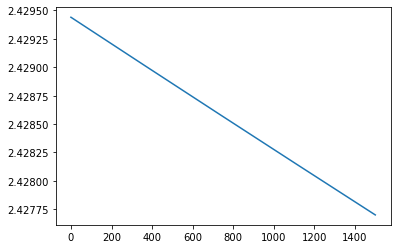

In [215]:
# 训练过程

# 保存loss值的list
loss = []
loss.append(calculate_loss(train_X, train_Y, W, b, lamda))

# 学习率
learning_rate = 0.0022
# 迭代100次
for i in range(1500):
    # 参数W，b进行梯度下降变化过程
    
    reg = W[1:]*(lamda/len(train_X))
    reg = np.insert(reg, 0, values=0, axis=0)
    
    t1 = W - learning_rate * np.dot(np.transpose(sigmoid(np.dot(train_X, W.T) + b) - train_Y), train_X) / len(train_X) - reg*learning_rate  
    t2 = b - learning_rate * np.sum(np.transpose(sigmoid(np.dot(train_X, W.T) + b) - train_Y), axis=1) / len(train_X)
    W = t1
    b = t2
    
    if (i+1)%500 == 0:
        print("已完成迭代%d"%(i+1) + "次")
        
    
    loss.append(calculate_loss(train_X, train_Y, W, b, lamda))
# 可视化显示迭代过程中的代价函数值
plt.plot(loss)
plt.show()

In [216]:
# 预测
res = sigmoid(np.dot(test_X, W.T) + b)
res_idx = np.argmax(res, axis=1)
test_idx = np.argmax(test_Y, axis=1)
cnt = 0
flag2 = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
flag1 = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
ss = [[0 for i in range(15)] for j in range(15)]
for i in range(len(res_idx)):
    flag1[test_idx[i]] += 1
    if res_idx[i] == test_idx[i]:
        cnt += 1
        flag2[test_idx[i]] += 1
    ss[test_idx[i]][res_idx[i]] += 1
print('总准确度为: ' + str(cnt/len(res_idx)))
print('零的识别度为' + str(flag2[0]/flag1[0]))
print('一的识别度为' + str(flag2[1]/flag1[1]))
print('二的识别度为' + str(flag2[2]/flag1[2]))
print('三的识别度为' + str(flag2[3]/flag1[3]))
print('四的识别度为' + str(flag2[4]/flag1[4]))
print('五的识别度为' + str(flag2[5]/flag1[5]))
print('六的识别度为' + str(flag2[6]/flag1[6]))
print('七的识别度为' + str(flag2[7]/flag1[7]))
print('八的识别度为' + str(flag2[8]/flag1[8]))
print('九的识别度为' + str(flag2[9]/flag1[9]))
print('十的识别度为' + str(flag2[10]/flag1[10]))
print('百的识别度为' + str(flag2[11]/flag1[11]))
print('千的识别度为' + str(flag2[12]/flag1[12]))
print('万的识别度为' + str(flag2[13]/flag1[13]))
print('亿的识别度为' + str(flag2[14]/flag1[14]))
print('混淆矩阵：')
for i in range(0,15):
    for j in range(0,15):
        print('%3d'%ss[i][j],end=' ')
    print()
for i in range(0,15):
    t1 = 0
    for j in range(0,15):
        t1 += ss[i][j]
    t2 = 0
    for j in range(0,15):
        t2 += ss[j][i]
    print(str(i) + '精确率: ' + str(ss[i][i]/t2))
    print(str(i) + '召回率: ' + str(ss[i][i]/t1))

总准确度为: 0.38
零的识别度为0.47619047619047616
一的识别度为0.2
二的识别度为0.3076923076923077
三的识别度为0.35
四的识别度为0.29411764705882354
五的识别度为0.09090909090909091
六的识别度为0.3333333333333333
七的识别度为0.5555555555555556
八的识别度为0.9047619047619048
九的识别度为0.18181818181818182
十的识别度为0.25
百的识别度为0.4444444444444444
千的识别度为0.3333333333333333
万的识别度为0.36363636363636365
亿的识别度为0.6666666666666666
混淆矩阵：
 10   0   7   4   0   0   0   0   0   0   0   0   0   0   0 
  3   4   1   0   1   0   2   2   0   0   1   4   1   0   1 
  2   0   8   0   3   0   0   3   0   4   0   1   1   4   0 
  4   0   0   7   0   2   4   1   0   0   0   1   1   0   0 
  2   0   2   0   5   0   1   1   0   1   0   3   1   0   1 
  4   0   0   6   1   2   8   1   0   0   0   0   0   0   0 
  0   0   0  11   2   1   7   0   0   0   0   0   0   0   0 
  2   1   0   0   2   0   1  10   0   0   0   1   1   0   0 
  0   0   0   0   0   0   0   1  19   0   0   0   0   1   0 
  4   0   3   2   3   0   2   0   0   4   1   1   1   1   0 
  4   1   2   1   0   0   0   0   0

<font face="微软雅黑" size=5 color=#A52A2A > 4.减少pca降维后的样本数量进行逻辑回归

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.io as sio
Y_pca = Y_pca[0 : 2000]
df = df[0 : 2000]
X_train_3, y_train_3, X_test_3, y_test_3 = trainTestSplit(Y_pca, df, 300, 0, 1)
print(len(y_test_3))
print(len(y_train_3))
train_X = X_train_3
train_Y = y_train_3.values
test_X =  X_test_3
test_Y = y_test_3.values
k = train_X.shape[1]  # k记录维度数量

300
1700


In [39]:
# 逻辑回归的sigmoid函数和计算cost function的函数
def sigmoid(z):
    return 1/(1+np.exp(-z))

lamda = 1
def calculate_loss(X, y, W, b, lamda):
    A = sigmoid(np.dot(X, W.T) + b)
    # 加1e-6是因为防止为0，log0不存在
    first = y * np.log(A + 1e-6)
    second = (1-y) * np.log(1-A + 1e-6)
    reg = np.sum(np.power(W[1:],2))*(lamda/(2*len(X)))
    
    
    return -np.sum(first+second)/len(X)

# 初始化W和b两个参数
np.random.seed(1)
W = np.random.rand(15, k)
b = np.ones(15)

已完成迭代500次
已完成迭代1000次
已完成迭代1500次
已完成迭代2000次
已完成迭代2500次
已完成迭代3000次
已完成迭代3500次
已完成迭代4000次
已完成迭代4500次
已完成迭代5000次


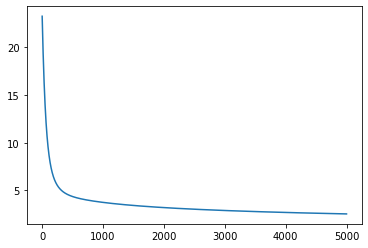

In [40]:
# 训练过程

# 保存loss值的list
loss = []
loss.append(calculate_loss(train_X, train_Y, W, b, lamda))

# 学习率
learning_rate = 0.05
# 迭代100次
for i in range(5000):
    # 参数W，b进行梯度下降变化过程
    
    reg = W[1:]*(lamda/len(train_X))
    reg = np.insert(reg, 0, values=0, axis=0)
    
    t1 = W - learning_rate * np.dot(np.transpose(sigmoid(np.dot(train_X, W.T) + b) - train_Y), train_X) / len(train_X) - reg*learning_rate  
    t2 = b - learning_rate * np.sum(np.transpose(sigmoid(np.dot(train_X, W.T) + b) - train_Y), axis=1) / len(train_X)
    W = t1
    b = t2
    
    if (i+1)%500 == 0:
        print("已完成迭代%d"%(i+1) + "次")
        
    
    loss.append(calculate_loss(train_X, train_Y, W, b, lamda))
# 可视化显示迭代过程中的代价函数值
plt.plot(loss)
plt.show()

In [41]:
# 预测
res = sigmoid(np.dot(test_X, W.T) + b)
res_idx = np.argmax(res, axis=1)
test_idx = np.argmax(test_Y, axis=1)
cnt = 0
flag2 = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
flag1 = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
ss = [[0 for i in range(15)] for j in range(15)]
for i in range(len(res_idx)):
    flag1[test_idx[i]] += 1
    if res_idx[i] == test_idx[i]:
        cnt += 1
        flag2[test_idx[i]] += 1
    ss[test_idx[i]][res_idx[i]] += 1
print('总准确度为: ' + str(cnt/len(res_idx)))
print('零的识别度为' + str(flag2[0]/flag1[0]))
print('一的识别度为' + str(flag2[1]/flag1[1]))
print('二的识别度为' + str(flag2[2]/flag1[2]))
print('三的识别度为' + str(flag2[3]/flag1[3]))
print('四的识别度为' + str(flag2[4]/flag1[4]))
print('五的识别度为' + str(flag2[5]/flag1[5]))
print('六的识别度为' + str(flag2[6]/flag1[6]))
print('七的识别度为' + str(flag2[7]/flag1[7]))
print('八的识别度为' + str(flag2[8]/flag1[8]))
print('九的识别度为' + str(flag2[9]/flag1[9]))
print('十的识别度为' + str(flag2[10]/flag1[10]))
print('百的识别度为' + str(flag2[11]/flag1[11]))
print('千的识别度为' + str(flag2[12]/flag1[12]))
print('万的识别度为' + str(flag2[13]/flag1[13]))
print('亿的识别度为' + str(flag2[14]/flag1[14]))
print('混淆矩阵：')
for i in range(0,15):
    for j in range(0,15):
        print('%3d'%ss[i][j],end=' ')
    print()
for i in range(0,15):
    t1 = 0
    for j in range(0,15):
        t1 += ss[i][j]
    t2 = 0
    for j in range(0,15):
        t2 += ss[j][i]
    print(str(i) + '精确率: ' + str(ss[i][i]/t2))
    print(str(i) + '召回率: ' + str(ss[i][i]/t1))

总准确度为: 0.38666666666666666
零的识别度为0.75
一的识别度为0.20833333333333334
二的识别度为0.3157894736842105
三的识别度为0.5333333333333333
四的识别度为0.3333333333333333
五的识别度为0.22727272727272727
六的识别度为0.4375
七的识别度为0.29411764705882354
八的识别度为0.42857142857142855
九的识别度为0.30434782608695654
十的识别度为0.4
百的识别度为0.3157894736842105
千的识别度为0.2777777777777778
万的识别度为0.22727272727272727
亿的识别度为0.7
混淆矩阵：
 21   0   0   1   0   3   0   0   0   1   2   0   0   0   0 
  0   5   1   1   4   1   2   1   1   1   3   0   2   2   0 
  0   1   6   0   1   1   1   1   1   0   0   0   5   1   1 
  0   0   0   8   2   2   0   0   0   0   0   2   0   1   0 
  0   3   4   0   7   0   2   1   1   0   1   0   0   0   2 
  5   0   0   3   0   5   0   0   5   2   1   1   0   0   0 
  0   2   0   0   1   1   7   2   0   0   0   0   0   2   1 
  0   1   2   0   1   1   0   5   2   2   0   2   1   0   0 
  4   0   1   0   1   2   0   2   9   1   0   0   0   1   0 
  3   0   2   1   3   0   0   2   1   7   0   0   3   1   0 
  0   2   0   0   0   0   2   0 